## Topics of hateful articles

Basado fuertemente en [esta notebook](https://github.com/kapadias/mediumposts/blob/master/nlp/published_notebooks/Evaluate%20Topic%20Models.ipynb)

En esta notebook veremos los tópicos de los artículos que generan cierto odio

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import json
from mongoengine import connect
from hatespeech_models import Tweet, Article

with open("../data/coronavirus-argentina-v2.json") as f:
    all_articles = json.load(f)

In [2]:
articles = [art for art in all_articles if len(art["comments"]) >= 20]

print(len(articles))


6519


In [3]:
sum(len(art["comments"]) for art in articles)

658976

In [4]:
from tqdm.auto import tqdm

for article in tqdm(articles):
    hateful_comments = [c for c in article["comments"] if c["hateful_value"] > 0.5]
    
    article["num_hateful_comments"] = len(hateful_comments)
    article["avg_hateful_comments"] = len(hateful_comments) / len(article["comments"])
    article["avg_hate_value"] = sum(c["hateful_value"] for c in article["comments"]) / len(article["comments"])


<AxesSubplot:>

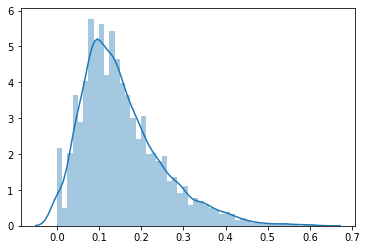

In [5]:
import seaborn as sns


sns.distplot([[art["avg_hateful_comments"] for art in articles]])

In [9]:
hateful_articles = [art for art in articles if art["avg_hateful_comments"] > 0.20]
len(hateful_articles)

1614

In [10]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
" - ".join(stop_words)

'de - la - que - el - en - y - a - los - del - se - las - por - un - para - con - no - una - su - al - lo - como - más - pero - sus - le - ya - o - este - sí - porque - esta - entre - cuando - muy - sin - sobre - también - me - hasta - hay - donde - quien - desde - todo - nos - durante - todos - uno - les - ni - contra - otros - ese - eso - ante - ellos - e - esto - mí - antes - algunos - qué - unos - yo - otro - otras - otra - él - tanto - esa - estos - mucho - quienes - nada - muchos - cual - poco - ella - estar - estas - algunas - algo - nosotros - mi - mis - tú - te - ti - tu - tus - ellas - nosotras - vosostros - vosostras - os - mío - mía - míos - mías - tuyo - tuya - tuyos - tuyas - suyo - suya - suyos - suyas - nuestro - nuestra - nuestros - nuestras - vuestro - vuestra - vuestros - vuestras - esos - esas - estoy - estás - está - estamos - estáis - están - esté - estés - estemos - estéis - estén - estaré - estarás - estará - estaremos - estaréis - estarán - estaría - estarías -

## Tokenizar

In [11]:
import spacy
from tqdm.auto import tqdm

nlp = spacy.load("es", disable=["parser", "ner"])

lemmatized_data = []

for art in tqdm(hateful_articles):
    lemmatized_data.append([t.lemma_.lower() for t in nlp(art["body"])])


In [12]:
import string

def is_punct_or_other(tok):
    return (tok in string.punctuation) or ("\n" in tok) or (len(tok) <= 3 and not tok.isalpha())


def filter_words(text):
    non_stop = [tok.strip() for tok in text if tok not in stop_words]
    non_punct = [tok for tok in non_stop if not is_punct_or_other(tok)]
    return non_punct

filtered_data = []

for text in tqdm(lemmatized_data):
    filtered_data.append(filter_words(text))

Sanity check

In [13]:


filter_words([t.string for t in nlp("Hola , esto. es una prueba e33 ?")])

['Hola', 'es', 'una', 'prueba']

In [14]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(filtered_data)

# Create Corpus
texts = filtered_data

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 8), (30, 1), (31, 1), (32, 2), (33, 1), (34, 2), (35, 3), (36, 3), (37, 1), (38, 1), (39, 1), (40, 1), (41, 4), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 2), (49, 2), (50, 4), (51, 11), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 2), (58, 4), (59, 3), (60, 4), (61, 1), (62, 8), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 2), (70, 9), (71, 1), (72, 1), (73, 2), (74, 3), (75, 2), (76, 2), (77, 2), (78, 4), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 4), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1), (91, 3), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [15]:
import gensim
import pickle

num_topics = range(2, 40, 2)
# Build LDA model

try:
    with open("topic_models_0.20.pkl", "rb") as f:
        lda_models, coherence_models = pickle.load(f)        
except FileNotFoundError:
    lda_models = {}
    coherence_models = {}

Se me borró el gráfico pero el que mejor daba es 14 

In [16]:

for num in tqdm(num_topics):
    if num in lda_models:
        continue
    model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num, 
        random_state=100,
        chunksize=100,
        passes=10,
        alpha='auto',
        per_word_topics=True)
    lda_models[num] = model
    coherence_models[num] = gensim.models.CoherenceModel(model, texts=texts, corpus=corpus, dictionary=id2word, coherence='c_v')


Salvamos esto

In [17]:
import pickle

with open("topic_models_0.20.pkl", "wb") as f:
    pickle.dump((lda_models, coherence_models), f)

In [18]:
Y = [k.get_coherence() for k in coherence_models.values()]

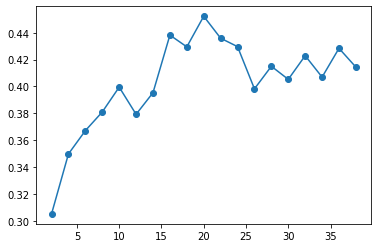

In [19]:
import matplotlib.pyplot as plt


plt.plot([k for k in coherence_models], Y, marker="o")

Agarro 16 que es el más chico donde más o menos deja de crecer

(acá separa mejor el tópico "mujeres" del resto)

In [44]:
lda_model = lda_models[16]

In [45]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.057*"mujer" + 0.027*"hijo" + 0.022*"marcelo" + 0.015*"parejo" + '
  '0.014*"instagram" + 0.014*"año" + 0.014*"video" + 0.014*"violencia" + '
  '0.014*"contar" + 0.013*"compartir"'),
 (1,
  '0.017*"parir" + 0.013*"presidente" + 0.012*"fernández" + 0.011*"gobierno" + '
  '0.010*"empresa" + 0.010*"gobernar" + 0.010*"ministro" + 0.009*"alberto" + '
  '0.008*"haber" + 0.008*"hoy"'),
 (2,
  '0.096*"gremio" + 0.011*"gremialista" + 0.010*"1300" + 0.010*"ojeda" + '
  '0.003*"acevedo" + 0.003*"discordia" + 0.002*"desesperante" + '
  '0.001*"empleados" + 0.000*"mercado" + 0.000*"docente"'),
 (3,
  '0.018*"juez" + 0.017*"justicia" + 0.012*"moyano" + 0.011*"prisión" + '
  '0.011*"social" + 0.010*"preso" + 0.010*"barrio" + 0.010*"judicial" + '
  '0.009*"denunciar" + 0.009*"causar"'),
 (4,
  '0.028*"ser" + 0.020*"parir" + 0.018*"haber" + 0.012*"país" + 0.009*"médico" '
  '+ 0.008*"coronavirus" + 0.008*"salud" + 0.007*"comer" + 0.007*"personar" + '
  '0.007*"año"'),
 (5,
  '0.040*"morales" +

In [46]:
# Print the Keyword in the 10 topics

doc_lda = lda_model[corpus]

In [48]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.303786 -0.284016       1        1  38.477342
4     -0.046586 -0.394702       2        1  19.453467
1     -0.179783 -0.345554       3        1  19.035835
10    -0.218693  0.292739       4        1   9.762455
3     -0.264682 -0.069757       5        1   5.083769
0     -0.444210 -0.005047       6        1   4.533911
14    -0.324302  0.255467       7        1   3.042965
15     0.172305  0.195299       8        1   0.297120
5      0.208688 -0.010686       9        1   0.091665
12     0.233673  0.023081      10        1   0.083642
13     0.212203  0.054299      11        1   0.066223
2      0.204900  0.086328      12        1   0.043988
11     0.184631  0.053706      13        1   0.015383
8      0.189374  0.049307      14        1   0.008690
9      0.188134  0.049768      15        1   0.001786
6      0.188134  0.049768      16        1   0.001760, topic_info=            Term          Freq         Total Category  logprob  loglift
263        mujer   1873.000000   1873.000000  Default  30.0000  30.0000
646   presidente   2165.000000   2165.000000  Default  29.0000  29.0000
359          ser  19379.000000  19379.000000  Default  28.0000  28.0000
1220   fernández   1891.000000   1891.000000  Default  27.0000  27.0000
1265    político   1297.000000   1297.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
9231        lula      0.000363      0.578630  Topic16 -10.2273   3.5734
9207         hdp      0.000363      0.578469  Topic16 -10.2273   3.5737
9206       flaca      0.000363      0.578437  Topic16 -10.2273   3.5738
9205      divina      0.000363      0.578439  Topic16 -10.2273   3.5738
9204  corticoide      0.000363      0.578453  Topic16 -10.2273   3.5738

[934 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
838       8  0.768656  -entre
3208     12  0.948146    1300
5524      9  0.860386    1500
9         1  0.143764    2020
9         2  0.027023    2020
...     ...       ...     ...
1595      2  0.305925    zona
1595      3  0.064206    zona
1595      4  0.608072    zona
1595      5  0.020773    zona
5549      9  0.759170    áñez

[1136 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 2, 11, 4, 1, 15, 16, 6, 13, 14, 3, 12, 9, 10, 7])

Palabras "seed": 

China, Cuba, Cubano, bolivia, Trump, judío, camionero, agresor, policía, ladrón, reprimir, represión, 
juez, justicia, penal, criminal, delito, denunciar
mamá, género, aborto, actriz, feminista, madre, femicidios, mujer, trans
cristina, macri, morales, canosa, evo

1. Tema "general" (verbos, y otras cosas)
2. Tema "internacional" (China, Trump, avión, extranjero, George Floyd, otros
3. AMBA/CABA: Kicillof, Larreta, Berni: política CABA, AMBA y demás
4. Uruguay, latinoamericanas?
5. Sindicales y Judiciales, las mezcla
6. Mujeres
7. JxC vs FDT: Macri, Cristina, expropiación, Senado, etc
8. RUIDO de acá en adelante


In [56]:
lda_model.get_topics().shape

(16, 27648)

In [68]:
temas = [
    "general",
    "internacional",
    "amba/caba",
    "latinoamérica",
    "sindicales, judiciales y policiales",
    "mujeres",
    "cambiemos vs fdt",
]

temas += [f"ruido-{i}" for i in range(lda_model.get_topics().shape[0] - len(temas))]

len(temas)

16

In [69]:
len(corpus), len(hateful_articles)

(1614, 1614)

In [70]:

def display_topics(num):
    print(hateful_articles[num]["title"])
    
    topics = lda_model.get_document_topics(corpus[num])
    
    print()
    
    print(" + ".join(f"{temas[idx]} * {porc:.2f}" for idx, porc in topics))


for num in range(len(hateful_articles)):
    print("=" * 80 + '\n\n')
    
    display_topics(num)



Alerta: confirman la primera muerte por sarampión en el país desde 1998

internacional * 0.18 + sindicales, judiciales y policiales * 0.72 + ruido-0 * 0.06 + ruido-3 * 0.02


Axel Kicillof: "Los expertos nos están recomendando fortalecer el aislamiento"

internacional * 0.66 + sindicales, judiciales y policiales * 0.14 + ruido-0 * 0.17 + ruido-3 * 0.03


Para el Gobierno, no se rompió el aislamiento

general * 0.01 + internacional * 0.28 + sindicales, judiciales y policiales * 0.29 + ruido-0 * 0.35 + ruido-3 * 0.03 + ruido-8 * 0.03


Insólito: un robo de celulares terminó en una batalla campal entre contagiados de coronavirus en el Centro de Aislamiento de Costa Salguero

general * 0.09 + internacional * 0.15 + latinoamérica * 0.06 + sindicales, judiciales y policiales * 0.42 + ruido-0 * 0.15 + ruido-3 * 0.14


Coronavirus en Argentina: en 10 días hubo más de 33 mil detenidos por incumplir el aislamiento

internacional * 0.10 + latinoamérica * 0.22 + sindicales, judiciales y policial

In [ ]:
lda_model.get_document_topics()